## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# Tarea1 Series de tiempo

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [5]:
# time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint
import pmdarima as pm #auto arima
import joblib #save models

## 2. Precipitación

In [138]:
precipitacion=pd.read_csv('Precipitacion.csv', index_col=0, parse_dates=True)
precipitacion.head()

,CDMX,Londres
Mes,,
Ene,7.6,55.2
Feb,7.0,40.9
Mar,8.9,41.6
Abr,22.5,43.7
May,66.5,49.4


In [139]:
precipitacion.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, Ene to Dic
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CDMX     12 non-null     float64
 1   Londres  12 non-null     float64
dtypes: float64(2)
memory usage: 288.0+ bytes


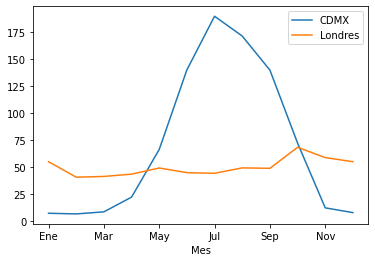

In [140]:
precipitacion.plot()
plt.show()

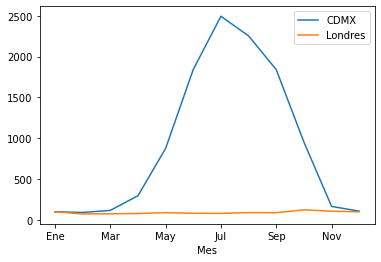

In [142]:
normalized=precipitacion.div(precipitacion.iloc[0]).mul(100).plot()


del gráfico normalizado, podríamos decir que con estos datos parece que londres tiene una precipitacion relativamente constante, mientras que CDMX cambia (aumenta) considerablemente con respecto al tiempo

### Analisis descriptivo

In [5]:
precipitacion.describe()

,CDMX,Londres
count,12.000000,12.000000
mean,70.516667,50.141667
std,70.887078,8.123083
min,7.000000,40.900000
25%,8.725000,44.300000
50%,44.500000,49.250000
75%,139.850000,55.200000
max,189.500000,68.500000


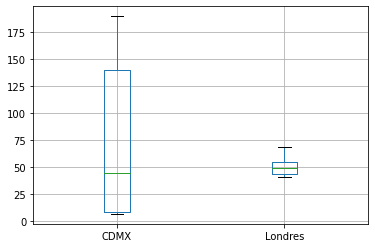

In [6]:
precipitacion.boxplot()

De los Boxplots con los datos disponibles parece que en CDMX llueve más que en londres

## t-test para diferencia en medias al 5%: 

${H_0}:{\mu _1} - {\mu _2} = 0$


Checando Normalidad univariada

In [8]:
#checa normalidad univariada
cities=precipitacion.columns
print('Shapiro test:')
for city in cities:
    W,p_v=stats.shapiro(precipitacion[city].values) #W>0.9 or p_v>0.05  Normalidad univariada 
    print('Ciudad: '+city+' W: '+str(np.round(W,3))+' p_v: '+str(np.round(p_v,3)))

Shapiro test:
Ciudad: CDMX W: 0.82 p_v: 0.016
Ciudad: Londres W: 0.911 p_v: 0.217


CDMX no sigue una distribución normal, aplicamos una transformación Box-Cox

In [13]:
#aproximar a normal
pt1 = PowerTransformer(method='box-cox') #‘yeo-johnson’ boxcox solo positivos
pt1.fit(precipitacion.values) #estima los lambdas optimos para la transformacion
X_t=pt1.transform(precipitacion.values) #aplica la transformacion a los datos
precipitacion_norm=pd.DataFrame(X_t)
precipitacion_norm.columns=cities

In [14]:
#checa normalidad univariada
cities=precipitacion.columns
print('Shapiro test:')
for city in cities:
    W,p_v=stats.shapiro(precipitacion_norm[city].values) #W>0.9 or p_v>0.05  Normalidad univariada 
    print('Ciudad: '+city+' W: '+str(np.round(W,3))+' p_v: '+str(np.round(p_v,3)))

Shapiro test:
Ciudad: CDMX W: 0.844 p_v: 0.031
Ciudad: Londres W: 0.964 p_v: 0.843


despues de aplicar la transformación suponemos normalidad para aplicar la prueba de diferencia de medias

In [15]:
print('t-test para diferencia en medias al 5%:')
_,pvalue=stats.ttest_ind(precipitacion_norm['CDMX'].values,precipitacion_norm['Londres'].values)
print(pvalue)

t-test para diferencia en medias al 5%:
0.9999999999993062


No hay evidencia suficiente para rechazar la hipotesis nula de diferencia de medias al 95%. es decir, ninguna es significativamente mayor al otro

## 3. indicador de consumo del mercado interior

Datos:

In [6]:
icmi=pd.read_csv('ICMI.csv', index_col=0, parse_dates=True, header=None)
icmi.columns=['ICMI']
icmi=icmi['2004':'2019']
icmi.head()

,ICMI
0,
2004-01-01,81.845818
2004-02-01,80.189762
2004-03-01,87.492810
2004-04-01,84.618686
2004-05-01,86.651602


In [7]:
icmi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2004-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ICMI    192 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [8]:
icmi.describe()

,ICMI
count,192.000000
mean,100.114868
std,9.987904
min,80.189762
25%,92.868459
50%,97.680476
75%,107.027365
max,121.698998


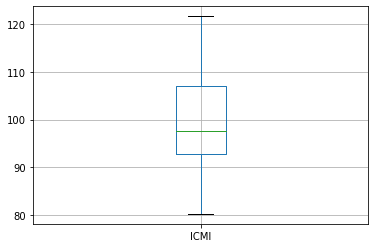

In [9]:
icmi.boxplot()

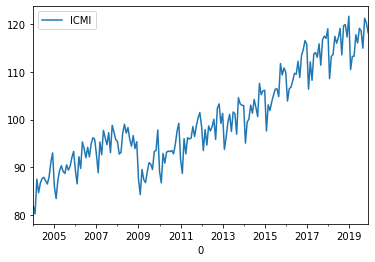

In [10]:
icmi.plot()
plt.show()

In [11]:
results=adfuller(icmi['ICMI'])
print('test statistic: '+str(results[0])+' p_val: '+str(results[1])+' Estacionaria? '+str(results[1]<0.05)) #p_val

test statistic: -0.7275274588875016 p_val: 0.8394898911480778 Estacionaria? False


Tiene tendencia, por lo tanto no es estacionaria y se necesita aplicar una transformación

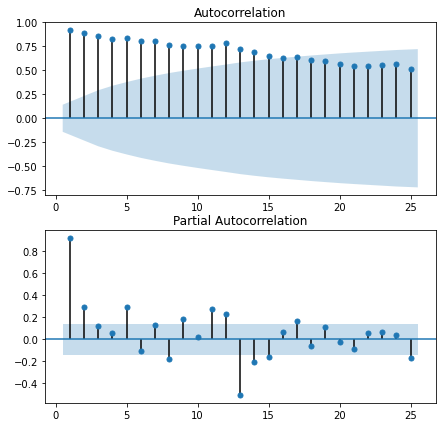

In [12]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(7,7))

plot_acf(icmi['ICMI'],lags=25, zero=False,ax=ax1)
plot_pacf(icmi['ICMI'],lags=25, zero=False,ax=ax2)
plt.show()

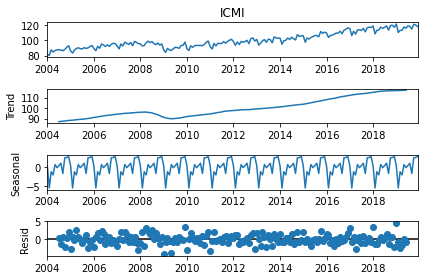

In [13]:
decom_results=seasonal_decompose(icmi['ICMI'], period=12)
decom_results.plot()
plt.show()

quitamos la tendencia

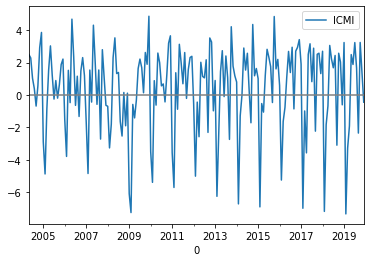

In [14]:
icmi_transf=icmi-icmi.rolling(5).mean()  #icmi_transf=icmi.diff().diff().dropna()
icmi_transf=icmi_transf.dropna()
icmi_transf.plot()
plt.axhline(y=0,color='grey', linestyle='-')
plt.show()

In [15]:
results=adfuller(icmi_transf['ICMI'])
print('test statistic: '+str(results[0])+' p_val: '+str(results[1])+' Estacionaria? '+str(results[1]<0.05)) #p_val

test statistic: -3.485359354361289 p_val: 0.008371154889062845 Estacionaria? True


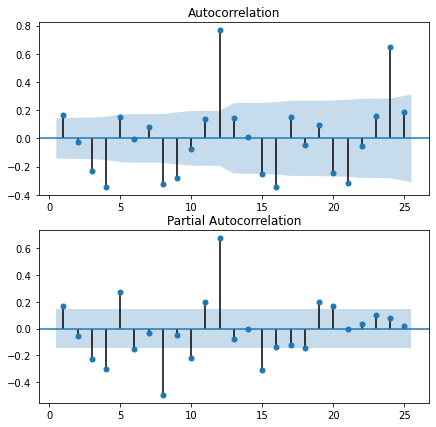

In [16]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(7,7))

plot_acf(icmi_transf['ICMI'],lags=25, zero=False,ax=ax1)
plot_pacf(icmi_transf['ICMI'],lags=25, zero=False,ax=ax2)
plt.show()

Parece que hay un comportamiento estacional con periodo de 12

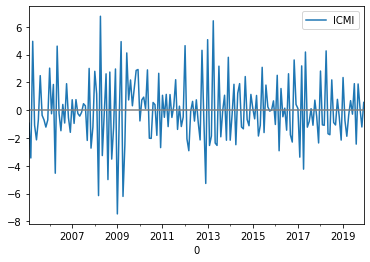

In [29]:
icmi_transf=icmi.diff().diff(12)  #icmi_transf=icmi.diff().diff().dropna()
icmi_transf=icmi_transf.dropna()
icmi_transf.plot()
plt.axhline(y=0,color='grey', linestyle='-')
plt.show()

In [30]:
results=adfuller(icmi_transf['ICMI'])
print('test statistic: '+str(results[0])+' p_val: '+str(results[1])+' Estacionaria? '+str(results[1]<0.05)) #p_val

test statistic: -4.203032164792937 p_val: 0.0006511561534811021 Estacionaria? True


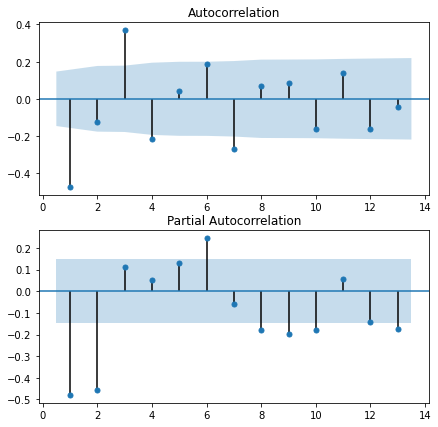

In [31]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(7,7))

plot_acf(icmi_transf['ICMI'],lags=13, zero=False,ax=ax1)
plot_pacf(icmi_transf['ICMI'],lags=13, zero=False,ax=ax2)
plt.show()

parece haber un patro de AR(2), p=2,q=0

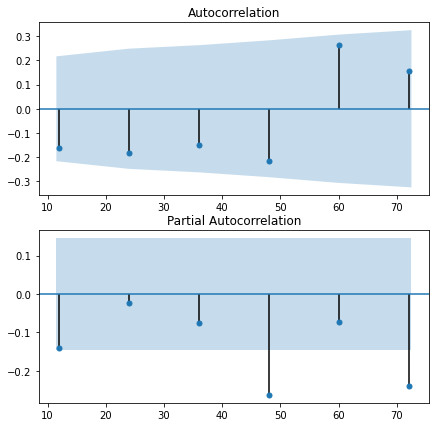

In [32]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(7,7))

plot_acf(icmi_transf['ICMI'],lags=[12,24,36,48,60,72], zero=False,ax=ax1)
plot_pacf(icmi_transf['ICMI'],lags=[12,24,36,48,60,72], zero=False,ax=ax2)
plt.show()

No hay algun patron visible para P,Q en los gráficos

Con Auto arima, considerando un modelo con componente estacionaria con periodo 12, con diferenciación en la parte no estacionaria y estacionaria, se busca el mejor modelo según el AIC:

In [81]:
model=pm.auto_arima(icmi,seasonal=True,d=1,D=1,m=12) #,d=2,start_p=1, start_q=1, max_p=5, max_q=5
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  192
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -343.775
Date:                              Fri, 25 Sep 2020   AIC                            697.550
Time:                                      11:52:54   BIC                            713.487
Sample:                                           0   HQIC                           704.012
                                              - 192                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7337      0.060    -12.187      0.000      -0.852      -0.616
ar.L2         -0.49

Prob(Q)>=0.05 y Prob(JB)>=0.05, los residuales no estan correlacionados, y son normales

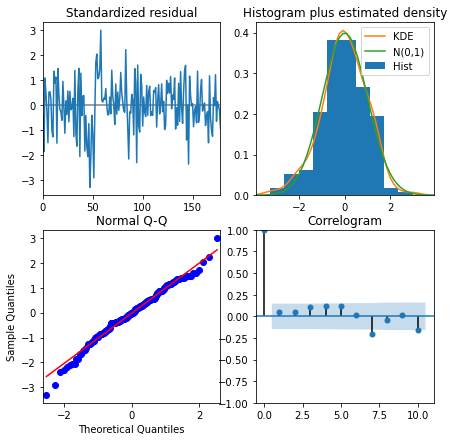

In [82]:
model.plot_diagnostics(figsize=(7,7))
plt.show()

En los residuales estandarizados no hay un patron obvio. Los hisTogramas se ajustan bien, y el Q-Q plot tambien se ajustabien a la linea roja indicando un normalidad. El correlograma tiene un punto un poco fuera de los intervalos de confianza los que podría indicar que hay información que no fue capturada por el modelo.

In [83]:
# Create model SARIMA(2,1,0)(1,1,1)12 object
model = SARIMAX(icmi,order=(2,1,0), seasonal_order=(1,1,1,12))
# Fit model
results = model.fit()

print(results.summary())

C:\Users\seema\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\seema\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                 ICMI   No. Observations:                  192
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -343.775
Date:                              Fri, 25 Sep 2020   AIC                            697.550
Time:                                      11:58:03   BIC                            713.487
Sample:                                  01-01-2004   HQIC                           704.012
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7337      0.060    -12.187      0.000      -0.852      -0.616
ar.L2         -0.49

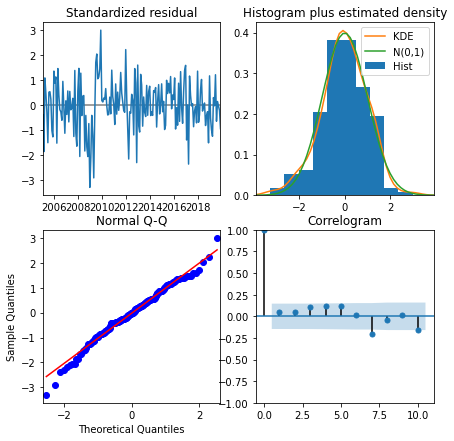

In [84]:
results.plot_diagnostics(figsize=(7,7))
plt.show()

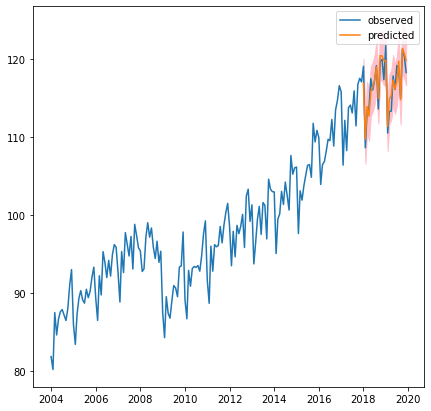

In [91]:
# one-step-ahead pred
forecast_object=results.get_prediction(start=-24)


# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

plt.figure(figsize=(7,7))

# Plot past 
plt.plot(icmi.index, icmi, label='observed')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink')

# Plot legend and show figure
plt.legend()
plt.show()

utilizando el modelo para predecir los 2 años anteriores, parece ajustarse bien

In [92]:
# Create forecast object
forecast_object = results.get_forecast(steps=24)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

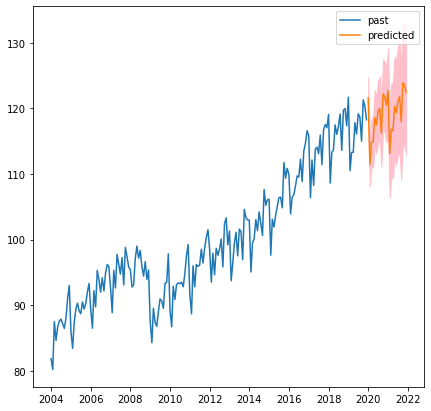

In [93]:
plt.figure(figsize=(7,7))

# Plot past 
plt.plot(icmi.index, icmi, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink')

# Plot legend and show figure
plt.legend()
plt.show()

predicción a los siguientes dos años

## 4. Índice nacional de precios al consumidor(p), Tipo de cambio nominal(E)

Datos

In [95]:
pass_thru=pd.read_csv('pass_thru.csv', index_col=0, parse_dates=True)
pass_thru.head()

,P,E
Periodo,,
1987-01-01,1.704401,0.9482
1987-02-01,1.827386,1.0450
1987-03-01,1.948153,1.0836
1987-04-01,2.118606,1.1501
1987-05-01,2.278325,1.2301


In [96]:
pass_thru.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 1987-01-01 to 2018-08-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P       380 non-null    float64
 1   E       380 non-null    float64
dtypes: float64(2)
memory usage: 8.9 KB


In [97]:
pass_thru.describe()

,P,E
count,380.000000,380.000000
mean,48.812059,9.518688
std,29.618792,4.903154
min,1.704401,0.948200
25%,14.786993,3.912525
50%,52.865957,10.195500
75%,73.628564,12.817075
max,100.492000,20.816500


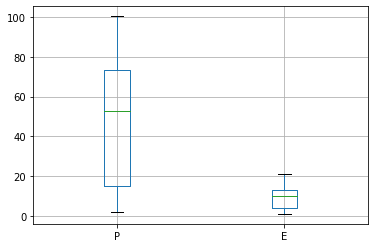

In [98]:
pass_thru.boxplot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000220C5A1DA90>,
      dtype=object)

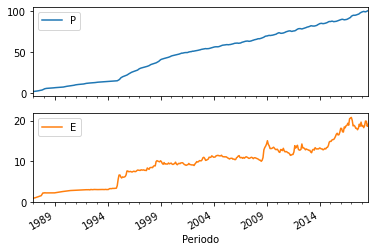

In [107]:
pass_thru.plot(subplots=True)

parece que ambas siguen una tendencia similar

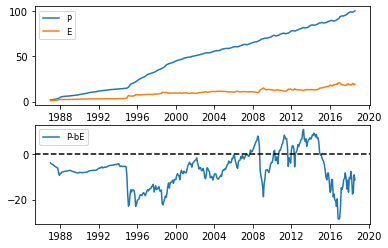

In [133]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(pass_thru['P'], label='P')
plt.plot(pass_thru['E'], label='E')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(pass_thru['P']-5.85*pass_thru['E'], label='P-bE')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

In [134]:
results=adfuller(pass_thru['P'])
print('P :''test statistic: '+str(results[0])+' p_val: '+str(results[1])+' Estacionaria? '+str(results[1]<0.1)+' RandomWalk? '+str(results[1]>=0.1)) #p_val
print()
results=adfuller(pass_thru['E'])
print('E :''test statistic: '+str(results[0])+' p_val: '+str(results[1])+' Estacionaria? '+str(results[1]<0.1)+' RandomWalk? '+str(results[1]>=0.1)) #p_val
print()
results=adfuller(pass_thru['P']-5.85*pass_thru['E'])
print('P-bE :''test statistic: '+str(results[0])+' p_val: '+str(results[1])+' Estacionaria? '+str(results[1]<0.1)+' RandomWalk? '+str(results[1]>=0.1)) #p_val

P :test statistic: 0.519538475559328 p_val: 0.9854550086785077 Estacionaria? False RandomWalk? True

E :test statistic: -0.15947698625703854 p_val: 0.9431826208190288 Estacionaria? False RandomWalk? True

P-bE :test statistic: -2.7492135232068877 p_val: 0.0659024154452972 Estacionaria? True RandomWalk? False


### No son estacionarias, Tienen tendencia y por lo tanto es necesario realizar alguna tranformación

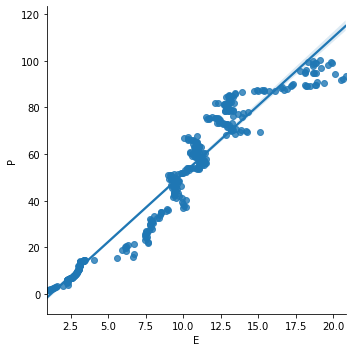

In [126]:
sns.lmplot("E", "P", data=pass_thru)

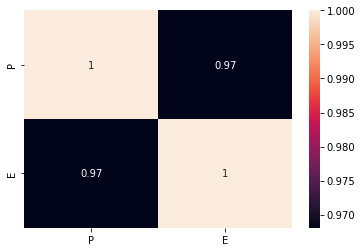

In [111]:

sns.heatmap(pass_thru.corr(), annot=True)

existe correlación positiva fuerte

In [135]:
_,pval,_=coint(pass_thru['P'],pass_thru['E'])
print(str(pval)+' cointegrate?: '+str(pval<0.2))

0.18121047371943294 cointegrate?: True


In [137]:
# Regress BTC on ETH
P=pass_thru['P'].values
E=pass_thru['E'].values
E = sm.add_constant(E)
result = sm.OLS(P,E).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(pass_thru['P'] - b*pass_thru['E'])
print("The p-value for the ADF test is ", adf_stats[1]) #p val<0.05
print("Cointegrate? ", adf_stats[1]<0.1) #p val<0.05

The p-value for the ADF test is  0.06610232316801212
Cointegrate?  True


In [129]:
b

5.847879841714194

por lo tanto la combinación lineal de ambas no es una caminata aleatoria, es estacionaria y por lo tanto se puede utilizar para predecir, entonces si existe cointegración